# Reference matching tutorial

In this tutorial you will learn how to map query to reference scATAC-seq dataset using cisTopic model of the data. This pipeline is a slightly modified version of [`hnoca-tools`](https://github.com/devsystemslab/HNOCA-tools/tree/main), which was developed for matching scRNA-seq data.

# Prepare reference

In [1]:
import os

os.environ["SCIPY_ARRAY_API"] = "1"

# Import required packages
import numpy as np
import pandas as pd
import scanpy as sc
from scarches.models.scpoli import scPoli  # Import scPoli directly
from atac_mapper.reference_mapping.mapping_atac import AtlasMapper
import scarches
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


Now that we've reloaded the module, we can proceed with the rest of the notebook. Remember to rerun this reload cell whenever you make changes to your package files.

In [2]:
adata_ref = sc.read_h5ad("../../../../test_data_atac_mapper/reference_adata_ZH.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 99732 × 175
    obs: 'Transcriptome', 'Strain', 'Sex', 'Method', 'Editat', 'Donor', 'NPeaks', 'is__cell_barcode', 'Chemistry', 'Ageunit', 'sample_id', 'DoubletFinderScore', 'duplicate', 'Neuronprop', 'Plugdate', 'Analysis', 'CellID', 'Shortname', 'Splits', 'peak_region_fragments', 'cisTopic_log_nr_frag', 'regions', 'peak_region_cutsites', 'Datecaptured', 'mitochondrial', 'Clusters_main', 'cisTopic_nr_frag', 'Agetext', 'Project', 'ClusterName', 'Editby', 'All_fc_analysis_id', 'TSS_fragments', 'Tissue', 'chimeric', 'SubClusters', 'Sampleok', 'Celltype', 'Cellclass', 'batch', 'conditions_combined', 'presence_max_MBO', 'isDA'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Agetext_colors', 'Cellclass_colors', 'Celltype_colors', 'Donor_colors', 'Shortname_colors', 'Tissue_colors', 'harmony', 'hvg', 'isDA_colors', 'neighbors', 'pca', 'scpoli', 'umap

In [3]:
adata_ref.X = adata_ref.layers["scaled"].copy()  # set scaled topic distribution as X

Let's train reference scPoli model. (Could be done on CPU, if no GPU are available, just takes more time).

In [4]:
adata_ref.obs["batch"] = adata_ref.obs["Donor"].copy()  # set Donor as batch
scpoli_model = scarches.models.scpoli.scPoli(
    adata=adata_ref,
    condition_keys="batch",
    cell_type_keys=["Cellclass", "Celltype"],
    unknown_ct_names=["Unknown"],
    hidden_layer_sizes=[128],
    latent_dim=20,
    embedding_dims=5,
    recon_loss="mse",  # needed for continious data as we have in topics
)

early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

Embedding dictionary:
 	Num conditions: [26]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 175 128 5
	Mean/Var Layer in/out: 128 20
Decoder Architecture:
	First Layer in, out and cond:  20 128 5
	Output Layer in/out:  128 175 



/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_metadata_ = adata.obs.groupby('conditions_combined').first()
/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_metadata_ = adata.obs.groupby(condition_keys).first()
/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:164: FutureWarning: Series.__getitem__ tre

In [5]:
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=35,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=20,
    batch_size=4096,
)

INFO:scarches.trainers.scpoli.trainer:GPU available: False


Initializing dataloaders
Starting training
 |██████████████------| 70.0%  - val_loss:   93.62 - val_cvae_loss:   93.62
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.


/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/trainers/scpoli/trainer.py:488: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(lat_adata, resolution=self.clustering_res)


Clustering succesful. Found 33 clusters.
 |████████████████████| 100.0%  - val_loss:  242.95 - val_cvae_loss:  163.74 - val_prototype_loss:   79.21 - val_unlabeled_loss:    2.10 - val_labeled_loss:    7.92


Let's save the model and get latent embeddings

In [6]:
scpoli_model.save("scpoli_reference_model", overwrite=True)

adata_ref.obsm["X_scpoli"] = scpoli_model.get_latent(adata_ref, mean=True)

/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  c = torch.tensor(label_tensor, device=device).T


Let's visualise the latent space embedding of the reference data

In [7]:
sc.pp.neighbors(adata_ref, use_rep="X_scpoli", key_added="scpoli")
sc.tl.umap(adata_ref, neighbors_key="scpoli")
adata_ref.obsm["X_umap_scpoli"] = adata_ref.obsm["X_umap"].copy()

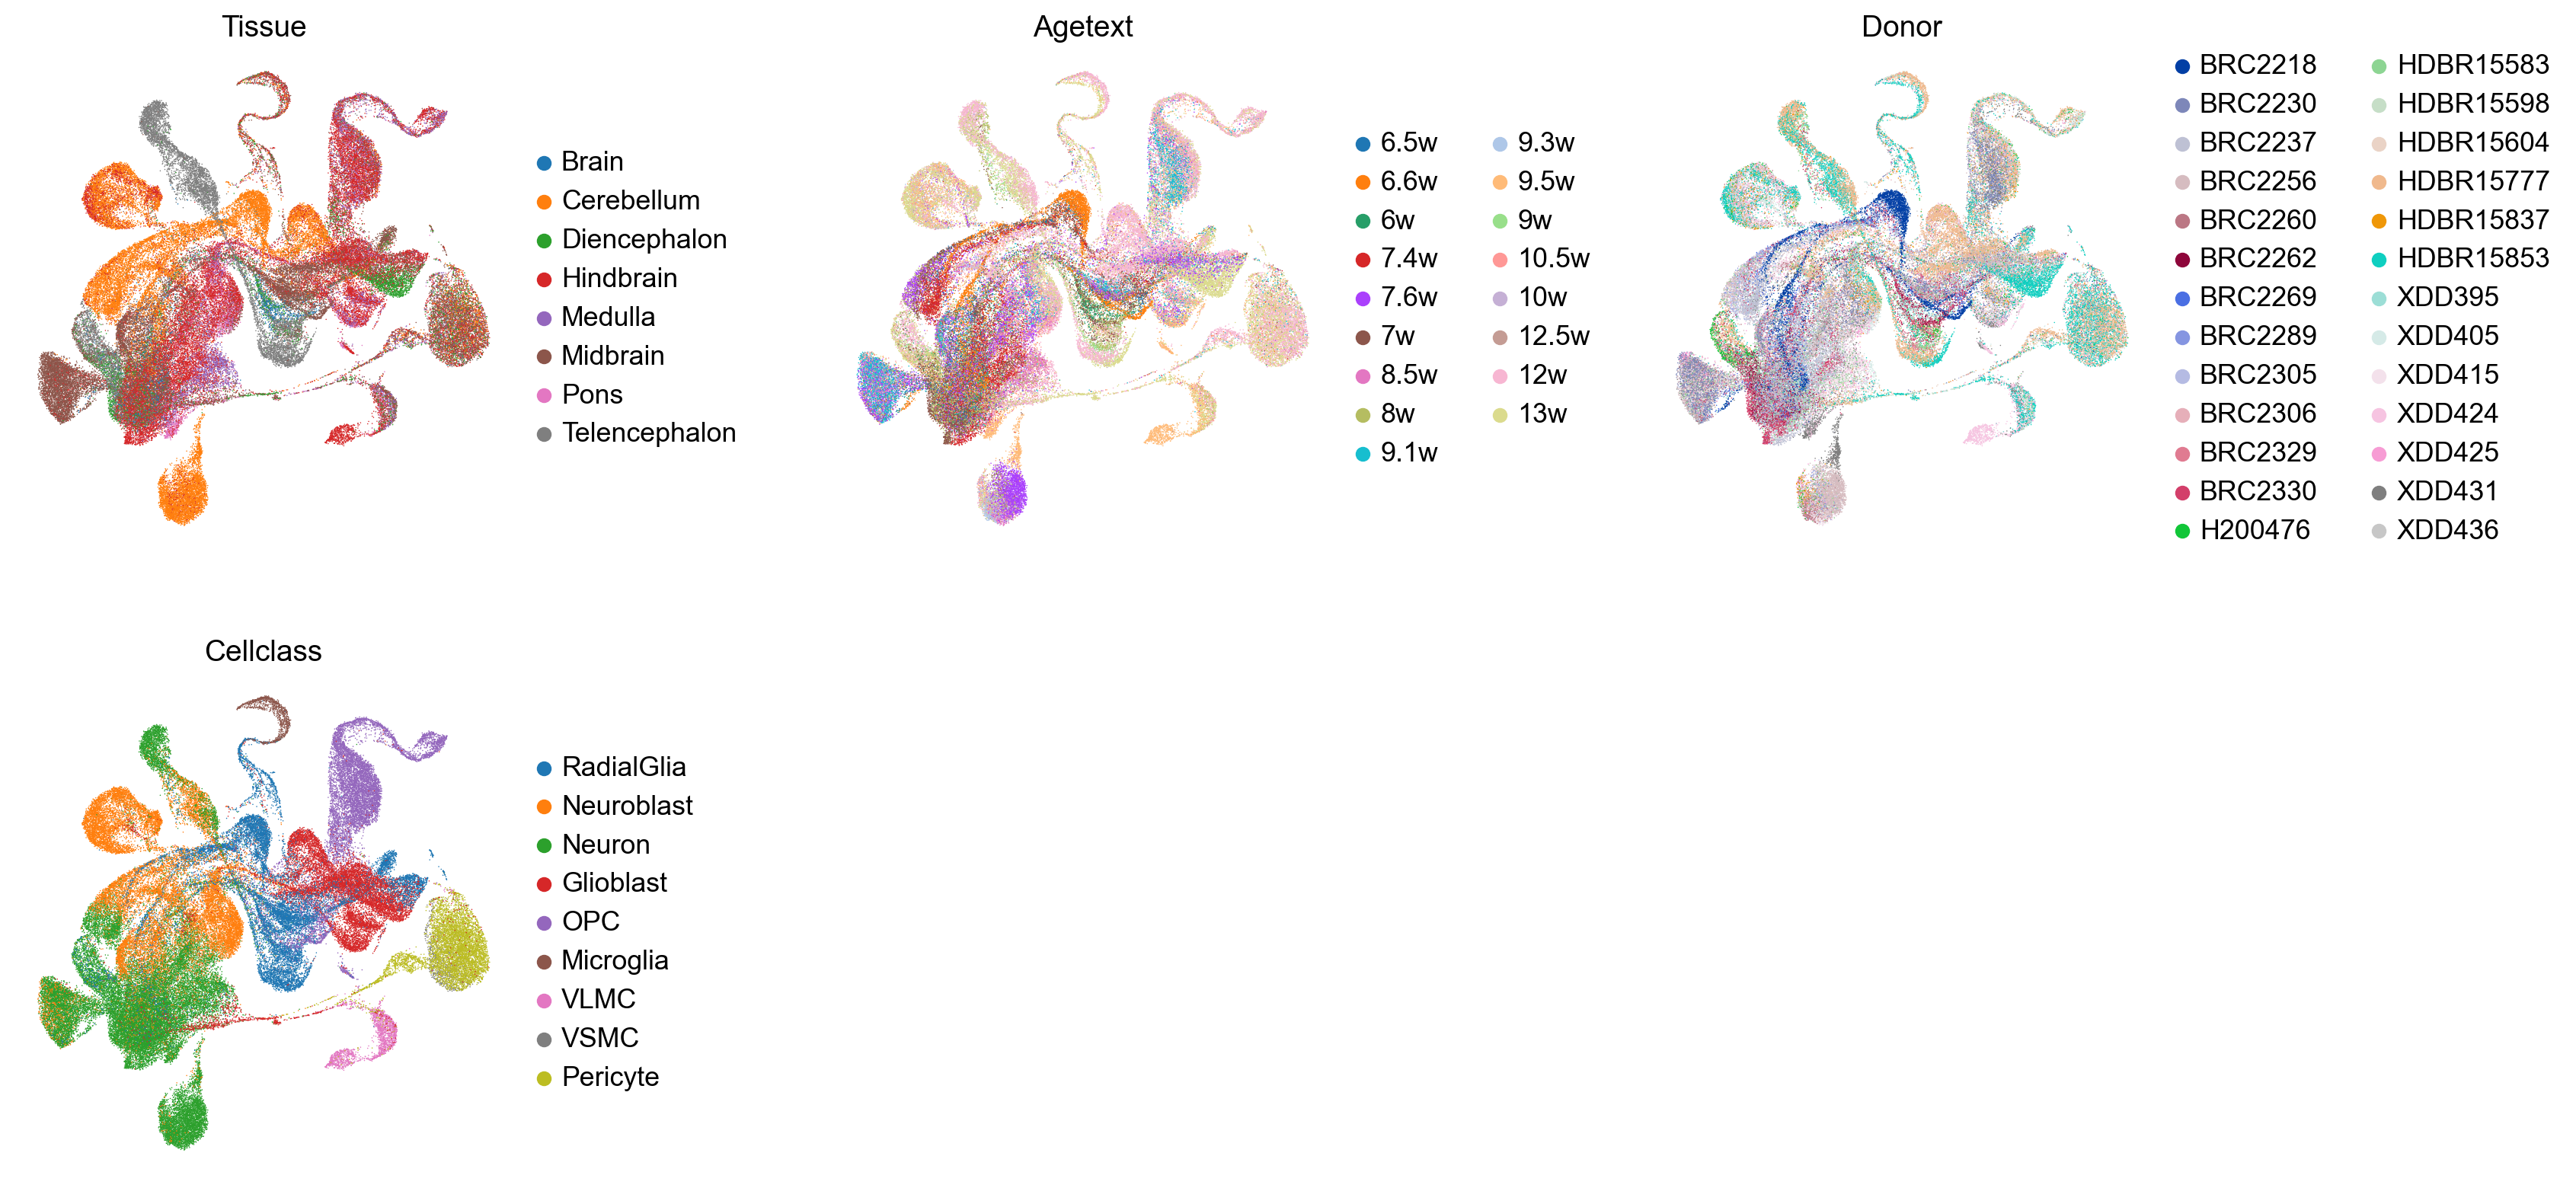

In [8]:
with plt.rc_context({"figure.figsize": (4, 4.5)}):
    sc.pl.embedding(
        adata_ref,
        basis="X_umap_scpoli",
        color=["Tissue", "Agetext", "Donor", "Cellclass"],
        frameon=False,
        ncols=3,
        wspace=0.5,
    )

# Map query data using scPoli model

In [9]:
# Load pre-trained scPoli model
ref_model = scPoli.load("scpoli_reference_model", adata=adata_ref)

# Initialize mapper with the loaded model
mapper = AtlasMapper(ref_model)

AnnData object with n_obs × n_vars = 99732 × 175
    obs: 'Transcriptome', 'Strain', 'Sex', 'Method', 'Editat', 'Donor', 'NPeaks', 'is__cell_barcode', 'Chemistry', 'Ageunit', 'sample_id', 'DoubletFinderScore', 'duplicate', 'Neuronprop', 'Plugdate', 'Analysis', 'CellID', 'Shortname', 'Splits', 'peak_region_fragments', 'cisTopic_log_nr_frag', 'regions', 'peak_region_cutsites', 'Datecaptured', 'mitochondrial', 'Clusters_main', 'cisTopic_nr_frag', 'Agetext', 'Project', 'ClusterName', 'Editby', 'All_fc_analysis_id', 'TSS_fragments', 'Tissue', 'chimeric', 'SubClusters', 'Sampleok', 'Celltype', 'Cellclass', 'batch', 'conditions_combined', 'presence_max_MBO', 'isDA'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Agetext_colors', 'Cellclass_colors', 'Celltype_colors', 'Donor_colors', 'Shortname_colors', 'Tissue_colors', 'harmony', 'hvg', 'isDA_colors', 'neighbors', 'pca', 'scpoli', 'umap

/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_metadata_ = adata.obs.groupby(condition_keys).first()


### Load Query Dataset

Now we'll load the query dataset (`atlas_500_test.h5ad`) that we want to map to our reference.

In [10]:
# Load query dataset
adata_query = sc.read_h5ad("../../../../test_data_atac_mapper/atlas_aftersymphony_cistopic_ZH.h5ad")
adata_query

AnnData object with n_obs × n_vars = 104452 × 175
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'experiment', 'done_by', 'sample', 'age', 'protocol', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'percent.mt', 'percent.rp', 'S.Score', 'G2M.Score', 'Phase', 'RNA.weight', 'ATAC.weight', 'RNA_snn_res.0.5', 'nCount_ATAC_main', 'nFeature_ATAC_main', 'score_NPC', 'score_neuron', 'neuron_NPC', 'annot_revised', 'seurat_clusters', 'Consensus_line', 'Line_quality', 'final_region2', 'annot_level_1', 'annot_level_2', 'annot_level_3', 'annot_level_4', 'gaus_scanvi_q2r', 'cell_types_NA_24', 'region_NA_24', 'fullname_NA_24', 'wsnn_res.20', 'Celltype', 'regions', 'symphony_per_cell_dist', 'Cellclass_wknn', 'Celltype_wknn', 'Agetext_wknn', 'Tissue_wknn', 'pearsonr_topics_Mannens_matched', 'euclidean_topics_Mannens_matched'
    uns: 'Cellclass_wknn_colors', 'Celltype_colors', 'Celltype_wknn_colors', 'Consensus_line_colors', 'Tiss

### Scale query to reference

In [11]:
adata_query.layers["Raw_topic"] = adata_query.X.copy()
adata_query.X = np.apply_along_axis(lambda x: (x - adata_ref.var["mean"]) / adata_ref.var["std"], 1, adata_query.X)
adata_query.X[adata_query.X > 10] = 10
adata_query.layers["scale2ref"] = adata_query.X.copy()

### Set Up Reference Mapping

We'll now set up the reference mapping using the AtlasMapper with the loaded reference model. The mapper will help us project the query data onto the reference space.

In [12]:
# Map query data to reference
adata_query.obs["batch"] = adata_query.obs["sample"].copy()

mapped_adata = mapper.map_query(
    query_adata=adata_query,
    retrain="partial",  # Freeze encoder weights but update other parameters
    n_epochs=25,
    pretraining_epochs=20,
    eta=5,
    batch_size=2048,
    lr=0.001,
    query_layer="scale2ref",  # Use the scaled layer for mapping
    embed_key="X_scpoli",  # Use the scPoli embedding
)

# Check the results
print("\nMapping complete!")

/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:784: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_obs_metadata = adata.obs.groupby('conditions_combined').first()
/Users/nazbukina/miniconda3/envs/mapper_test/lib/python3.10/site-packages/scarches/models/scpoli/scpoli_model.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.obs_metadata_ = adata.obs.groupby(condition_keys).first()
INFO:scarches.trainers.scpoli.trainer:GPU available: False


Embedding dictionary:
 	Num conditions: [38]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 175 128 5
	Mean/Var Layer in/out: 128 20
Decoder Architecture:
	First Layer in, out and cond:  20 128 5
	Output Layer in/out:  128 175 

Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss:  129.00 - val_cvae_loss:  129.00
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 31 clusters.
 |████████████████████| 100.0%  - val_loss:  132.65 - val_cvae_loss:  132.65 - val_prototype_loss:    0.00 - val_unlabeled_loss:    0.11

Mapping complete!


Let's compute UMAP of the query data using latent representation, that we've computed using scPoli

In [13]:
sc.pp.neighbors(mapped_adata, use_rep="X_scpoli", key_added="scpoli_primary")
sc.tl.umap(mapped_adata, neighbors_key="scpoli_primary")
mapped_adata.obsm["X_umap_scpoli"] = mapped_adata.obsm["X_umap"].copy()

In [15]:
mapper.save("scpoli_atlas_mapper")
# Save the final model

## Visualize Results

Let's visualize the mapping results to see how well the query data aligns with the reference. For this we would use [CellMapper package](https://cellmapper.readthedocs.io/en/latest/index.html).

In [16]:
import cellmapper

In [17]:
cmap = cellmapper.CellMapper(query=mapped_adata, reference=adata_ref)
cmap.compute_neighbors(use_rep="X_scpoli", only_yx=False, n_neighbors=50)
cmap.compute_mapping_matrix("hnoca")  # jaccard_square weighting scheme
cmap.map_obs(key="Cellclass", prediction_postfix="primary")  # we transfer Cellclass labels

INFO     Initialized CellMapper with 104452 query cells and 99732 reference cells.                                 
INFO     Using sklearn to compute 50 neighbors.                                                                    
INFO     Computing mapping matrix using method 'hnoca'.                                                            
INFO     Row-normalizing the mapping matrix.                                                                       
INFO     Mapping categorical data for key 'Cellclass' using one-hot encoding.                                      
INFO     Categorical data mapped and stored in query.obs['Cellclass_primary'].                                     


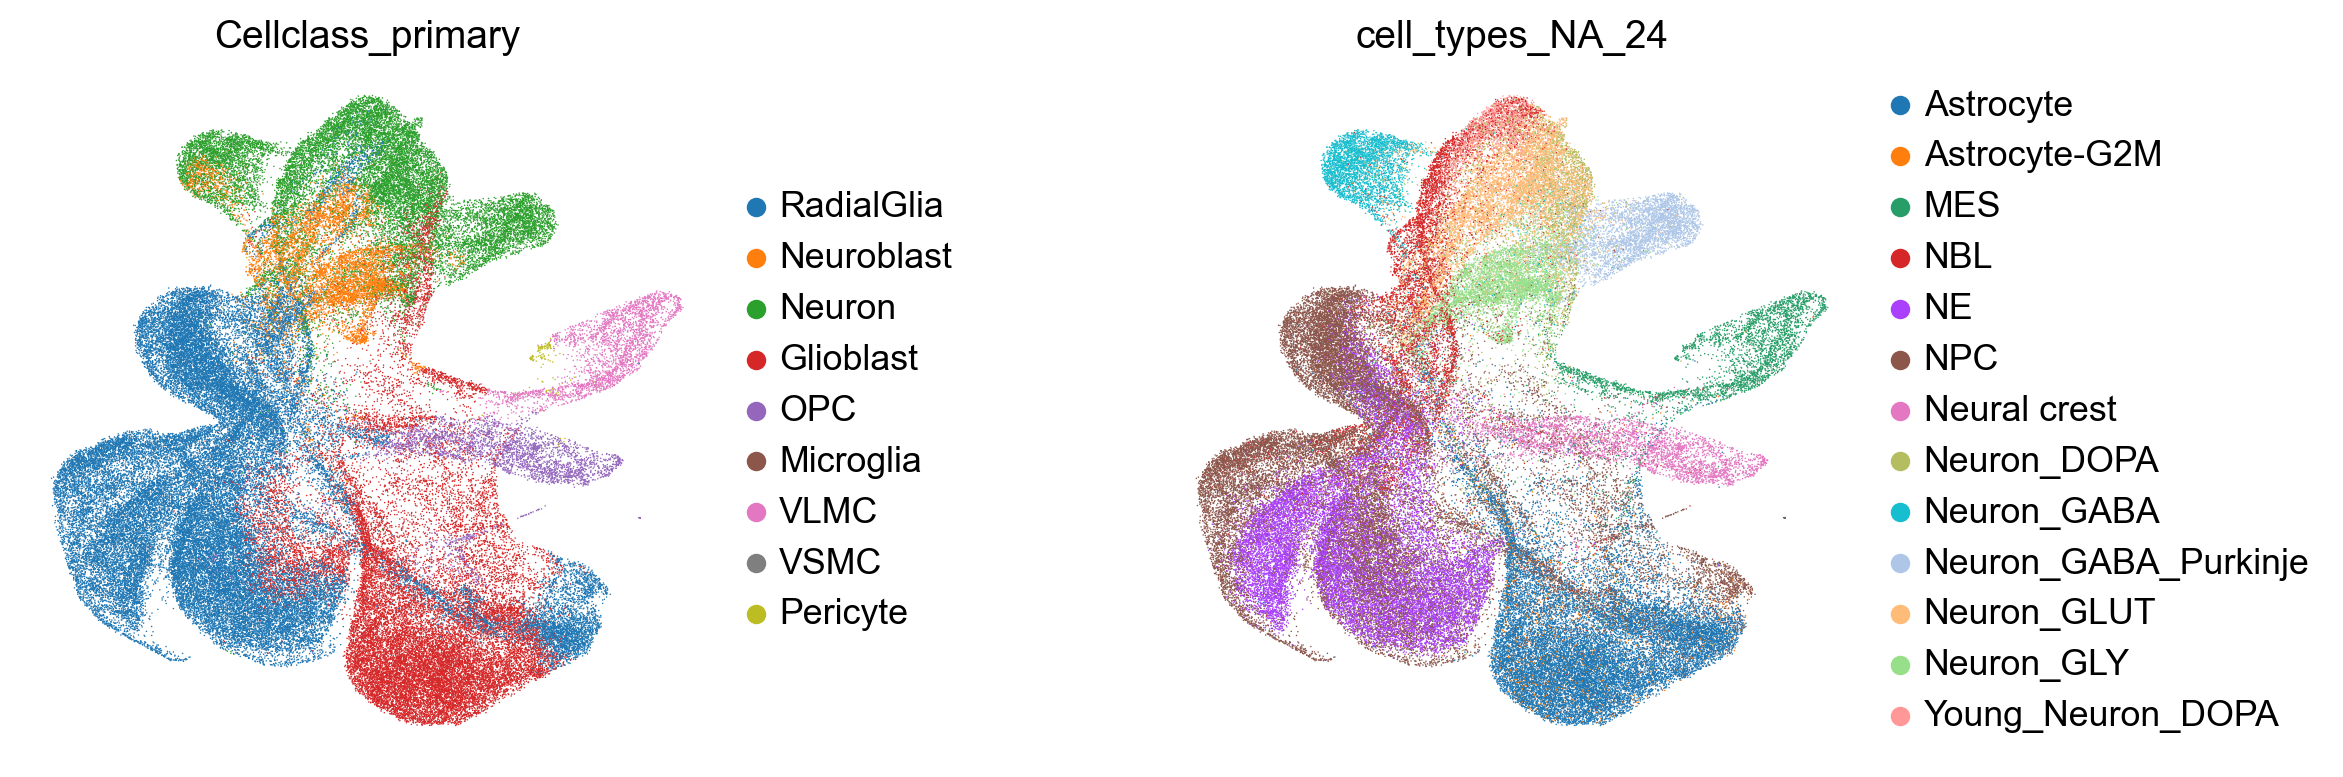

In [18]:
with plt.rc_context({"figure.figsize": (4, 4.5)}):
    sc.pl.embedding(
        mapped_adata,
        basis="X_umap_scpoli",
        color=["Cellclass_primary", "cell_types_NA_24"],  # let's visualise transferred labels and annotated cell types
        frameon=False,
        ncols=2,
        wspace=0.5,
    )

In [27]:
freq_ct_regions = pd.crosstab(mapped_adata.obs.cell_types_NA_24, mapped_adata.obs.Cellclass_primary)

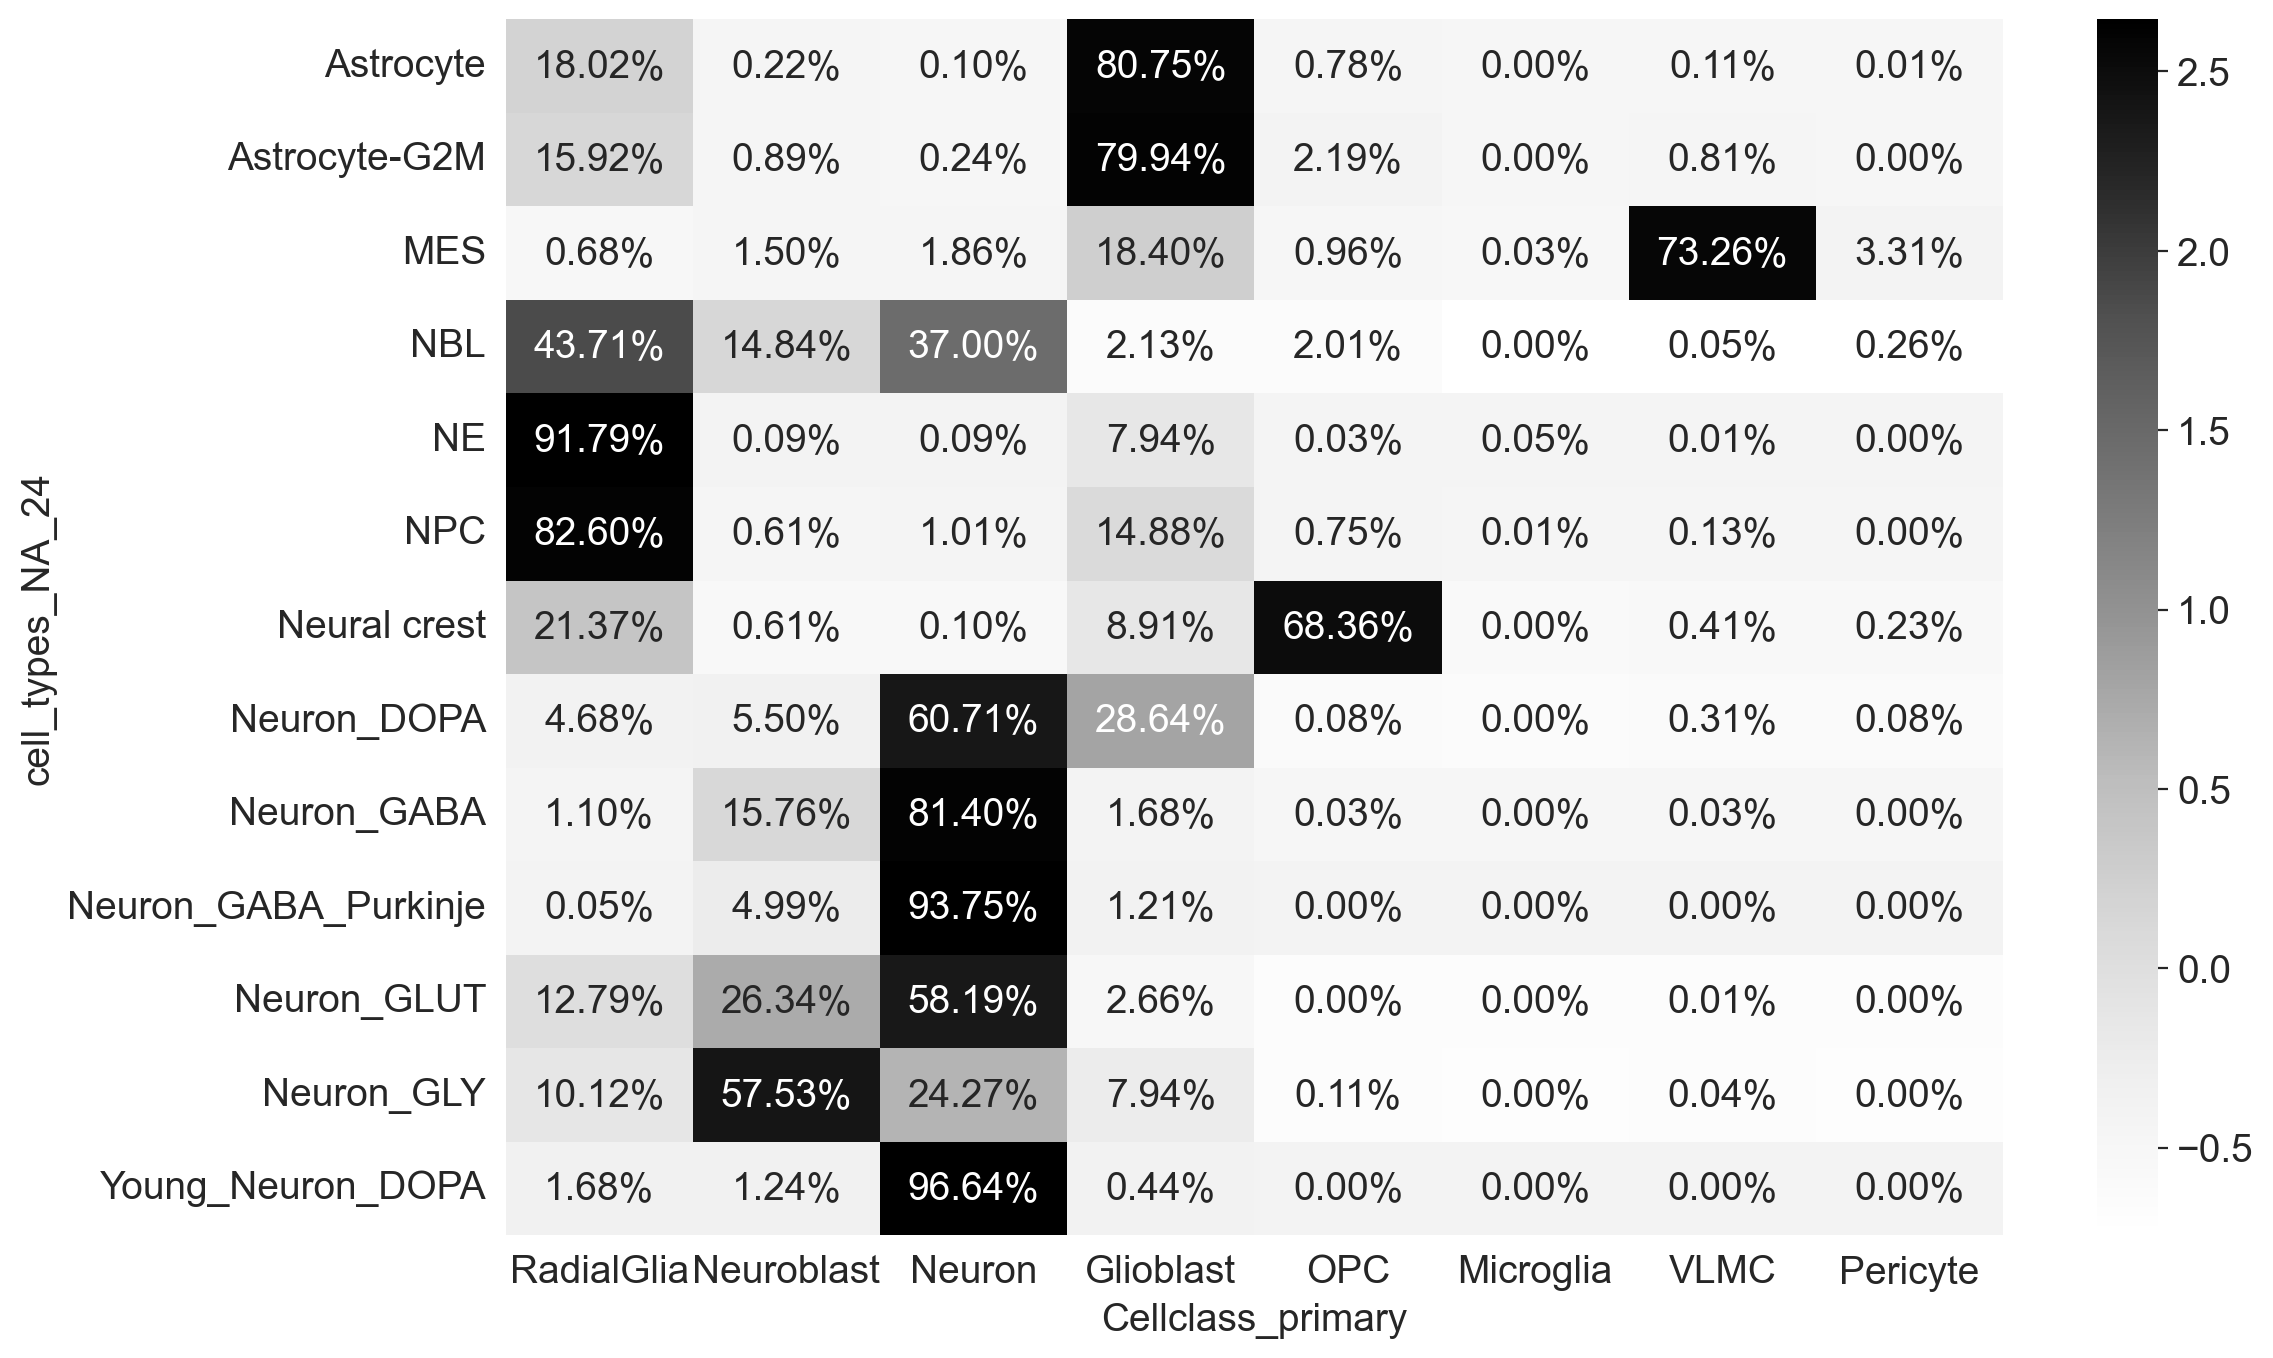

In [28]:
sns.set_style("white")
prop_ct_regions = freq_ct_regions.apply(lambda x: x / np.sum(x), axis=1)
mat = prop_ct_regions.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=1)
with plt.rc_context({"figure.figsize": (12, 8)}):
    svm = sns.heatmap(mat, annot=prop_ct_regions, cmap="Greys", fmt=".2%")
plt.show()

In [31]:
cmap.estimate_presence_score(
    key_added="MBO_presence_score", groupby="sample"
)  # calculate presence score for each cell type in each sample in query data

adata_ref.obs["MBO_presence_score"] = (
    adata_ref.obsm["MBO_presence_score"].max(axis=1) ** 0.5
)  # let's take the maximum presence score for each reference cell across samples

INFO     Presence score across all query cells computed and stored in `reference.obs['MBO_presence_score']`        
INFO     Presence scores per group defined in `query.obs['sample']` computed and stored in                         
         `reference.obsm['MBO_presence_score']`                                                                    


We can smoothen calculated presence scores.

In [32]:
smap = cellmapper.CellMapper(query=adata_ref)
smap.compute_neighbors(use_rep="X_scpoli", n_neighbors=50)
smap.compute_mapping_matrix("gaussian")
smap.map_obs(key="MBO_presence_score")

INFO     Initialized CellMapper for self-mapping with 99732 cells.                                                 
INFO     Using sklearn to compute 50 neighbors.                                                                    
INFO     Computing mapping matrix using method 'gaussian'.                                                         
INFO     Row-normalizing the mapping matrix.                                                                       
INFO     Mapping numerical data for key 'MBO_presence_score' using direct matrix multiplication.                   
INFO     Numerical data mapped and stored in query.obs['MBO_presence_score_pred'].                                 


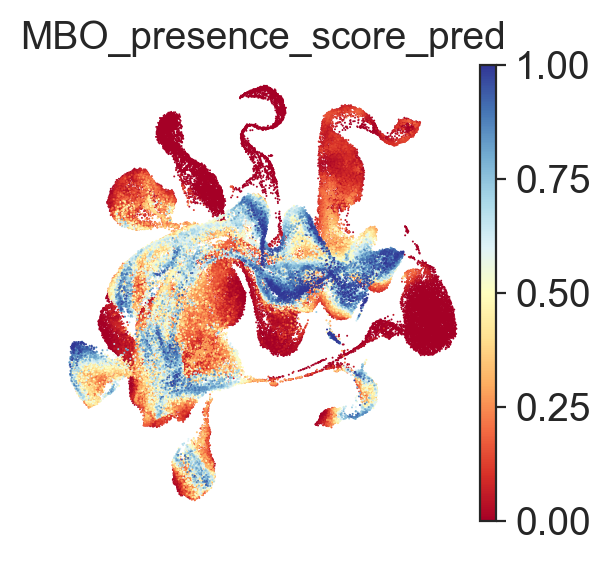

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.embedding(
    adata_ref,
    basis="X_umap_scpoli",
    color=["MBO_presence_score_pred"],
    frameon=False,
    ncols=1,
    wspace=0.5,
    color_map="RdYlBu",
    ax=ax,
    show=False,
    size=2,
)
plt.show()